# Uncertainty estimation using ensembles of partly independent MLP models

-- Network outputs two values in the final layer, corresponding to the predicted **mean** and **variance** by treating the observed value as a sample from a Gaussian distribution

-- Ensemble members are trained on different bootstrap samples of the original training set


In [2]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
from astropy.io import fits
import numpy.ma as ma
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.models_mlp import MlpPartlyIndepNet
from inverse_problem.nn_inversion.transforms import normalize_output
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion.transforms import inverse_transformation
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
from inverse_problem.nn_inversion.posthoc import plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion import mlp_transform_rescale, normalize_spectrum

### Define ensemble size

In [11]:
ensemble_size = 3

### Load data

In [7]:
filename = '../data/parameters_base_new.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

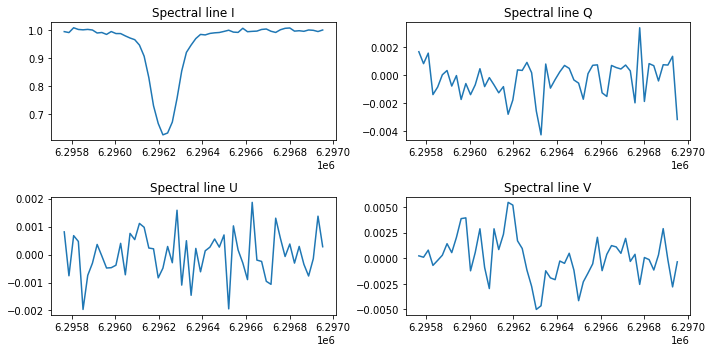

In [26]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Prepare data for training

Options:
-- angle transformation
-- log transformation

In [8]:
params = fits.open(filename)[0].data
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

In [9]:
MLP  = True
factors, cont_scale = [1,1000,1000,1000], 40000
angle_transformation, logB = False, True



if MLP:
    transform_name = "mlp_transform_rescale"
    batch_size = 20
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name,
                                           factors = factors, cont_scale = cont_scale,
                                           logB = logB, angle_transformation = angle_transformation,
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
else:
    transform_name = "conv1d_transform_rescale"
    batch_size = 128
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name,
                                           factors = factors, cont_scale = cont_scale,
                                           logB = logB, angle_transformation = angle_transformation,
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)


torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])


In [59]:
data_loader = [make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors = factors, cont_scale= cont_scale,
                                       angle_transformation = angle_transformation, logB = logB,
                                       batch_size=128) for _ in range(ensemble_size)]

# print characteristics for the first model in the ensemble
sample_batch = next(iter(data_loader[0][0]))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(data_loader[0][0])}, for validation: {len(data_loader[0][1])}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 31243, for validation: 3472


### Create path for saving

In [30]:
model_name = 'unc_pred'
current_time = str(datetime.now().strftime('%m-%d_%H-%M'))
save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../unc_pred_02-08_20-07/'

### Define ensemble

output_dim=22 for uncertainty estimation

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = [MlpPartlyIndepNet(input_dim=224, output_dim=22, hidden_dims=[200, 200, 200],
                              activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2).to(device) for _ in range(ensemble_size)]

In [12]:
criterion = nn.MSELoss()
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99)) for model in ensemble]

In [13]:
def mdn_cost(mu, sigma, y):
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))


def fit_step(model, optimizer, dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            optimizer.zero_grad()

            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(10)
        return train_loss / train_it


def eval_step(model, dataloader, max_steps = None):
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        if i==total:
            break
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).msean()
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it

In [ ]:
def save_model(model, optimizer, epoch, loss, path='../'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + f'ep{epoch}.pt')

### Train model

In [55]:
# %%time
# max_train_steps = 500
# max_val_steps = 100
# best_valid_loss = [float('inf') for i in range(ensemble_size)]
#
# history = [[] for i in range(ensemble_size)]
# loss_history = [[] for i in range(ensemble_size)]
#
# log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
# n_epochs = 1
# log_dir=save_path
#
#
# with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
#     for epoch in range(n_epochs):
#         val_losses = []
#         train_losses = []
#         for i, model in enumerate(ensemble):
#             optimizer = optimizers[i]
#             train_loss = fit_step(model, optimizer, data_loader[i][0], max_train_steps)
#             val_loss = eval_step(model, data_loader[i][1], max_val_steps)
#
#             history.append((train_loss, val_loss))
#             if val_loss < best_valid_loss[i]:
#                 best_valid_loss[i] = val_loss
#                 save_model(model, optimizer, epoch, val_loss, save_path + 'model_' + str(i) + '_')
#
#             val_losses.append(val_loss)
#             train_losses.append(train_loss)
#
#
#         val_loss, train_loss = min(val_losses), min(train_losses)
#         pbar_outer.update(1)
#         tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
#                                                v_loss=val_loss))
#
#


epoch: 100%|██████████| 1/1 [03:45<00:00, 225.74s/it]

-1.5979762852191925 -1.455673513174057

Epoch 001 train_loss: -1.4557 val_loss -1.5980
CPU times: user 4min 15s, sys: 4.94 s, total: 4min 20s
Wall time: 3min 45s


### Load the ensemble weights

In [14]:
save_path = '../ensembles_9_02/'
n_epochs = 3

for i, model in enumerate(ensemble):
    model.load_state_dict(torch.load(save_path + 'model_' + str(i) + '_ep' + str(n_epochs - 1) + '.pt', map_location=device)['model_state_dict'])

## Results analysis
### Simulation based on the refer file

Data source: https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [15]:
path_to_refer = '../data/sp_20140926_170005/20140926_170005.fits'
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB)
print(data.shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


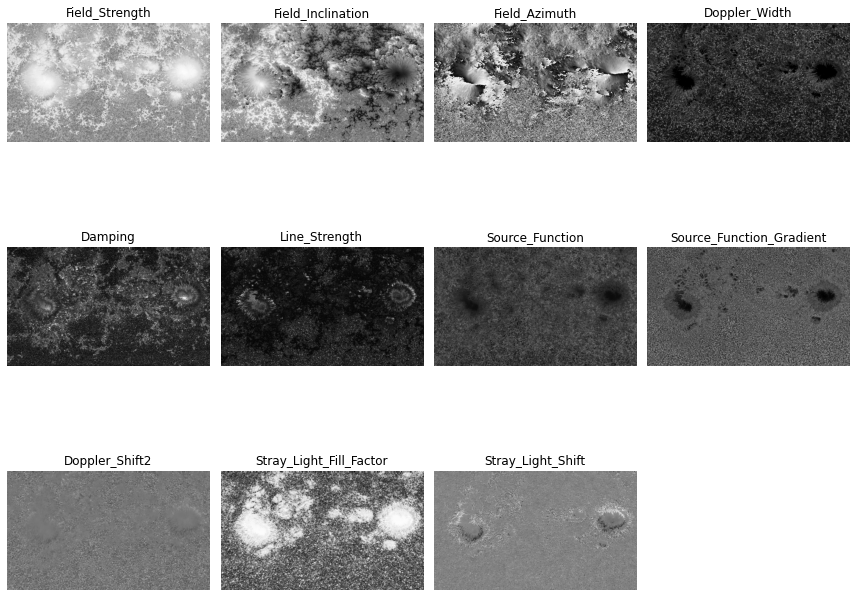

In [16]:
plot_params(data, names=names)

In [17]:
%%time
transform = mlp_transform_rescale(factors = factors, angle_transformation=angle_transformation,
                                  cont_scale=cont_scale, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 37.9 s, sys: 24 s, total: 1min 1s
Wall time: 1min 15s


In [18]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [25]:
%%time

predicted_mean = np.zeros((ensemble_size, 446976, 11))
predicted_sigma = np.zeros((ensemble_size, 446976, 11))

for i, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        predicted = model(sim_x)

    predicted_mean[i] = predicted[:, :11].detach().cpu().numpy()
    predicted_sigma[i] = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

CPU times: user 1min 25s, sys: 19.3 s, total: 1min 44s
Wall time: 1min 16s


In [26]:
refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)

refer_shape = refer_unnormalized.shape

print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


In [27]:
ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)

refer = ref_2d.reshape(refer_shape).copy()

In [28]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)
masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

In [57]:
compute_metrics(masked_ref_2d.data, predicted_mean[1],
                save_path=save_path + 'metrics.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.9532,0.0007,0.0165
Field Inclination,0.9834,0.0007,0.0143
Field Azimuth,0.7183,0.0216,0.0677
Doppler Width,0.9549,0.0007,0.0182
Damping,0.9403,0.0010,0.0192
Line Strength,0.7678,0.0018,0.0184
S_0,0.8773,0.0005,0.0156
S_1,0.9752,0.0002,0.0102
Doppler Shift,0.9469,0.0001,0.0047
Filling Factor,0.8463,0.0088,0.0642


In [32]:
compute_metrics(masked_ref_2d.data, predicted_mean[1],
                save_path=save_path + 'metrics.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.9532,0.0007,0.0165
Field Inclination,0.9834,0.0007,0.0143
Field Azimuth,0.7183,0.0216,0.0677
Doppler Width,0.9549,0.0007,0.0182
Damping,0.9403,0.0010,0.0192
Line Strength,0.7678,0.0018,0.0184
S_0,0.8773,0.0005,0.0156
S_1,0.9752,0.0002,0.0102
Doppler Shift,0.9469,0.0001,0.0047
Filling Factor,0.8463,0.0088,0.0642


In [35]:
predicted_mean_overall = np.mean(predicted_mean, axis = 0)
predicted_sigma_overall  = np.sqrt(np.mean(predicted_sigma + np.square(predicted_mean), axis = 0) - np.square(predicted_mean_overall))

In [37]:
compute_metrics(masked_ref_2d.data, predicted_mean_overall,
                save_path=save_path + 'metrics.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.9555,0.0007,0.0155
Field Inclination,0.9842,0.0006,0.0135
Field Azimuth,0.7501,0.0192,0.0643
Doppler Width,0.9646,0.0006,0.0158
Damping,0.9522,0.0008,0.0172
Line Strength,0.7839,0.0017,0.0176
S_0,0.8885,0.0004,0.0148
S_1,0.9779,0.0002,0.0096
Doppler Shift,0.9495,0.0001,0.0044
Filling Factor,0.8569,0.0083,0.0612


In [44]:
from inverse_problem.nn_inversion.transforms import inverse_transformation

inv_angle_transformation = angle_transformation
true = np.array(inverse_transformation(ref_2d, inv_angle_transformation=inv_angle_transformation))
pred = np.array(inverse_transformation(predicted_mean_overall, inv_angle_transformation=inv_angle_transformation))
sigma = np.array(inverse_transformation(predicted_sigma_overall, sigma=True, inv_angle_transformation=inv_angle_transformation, mean=predicted_mean_overall))

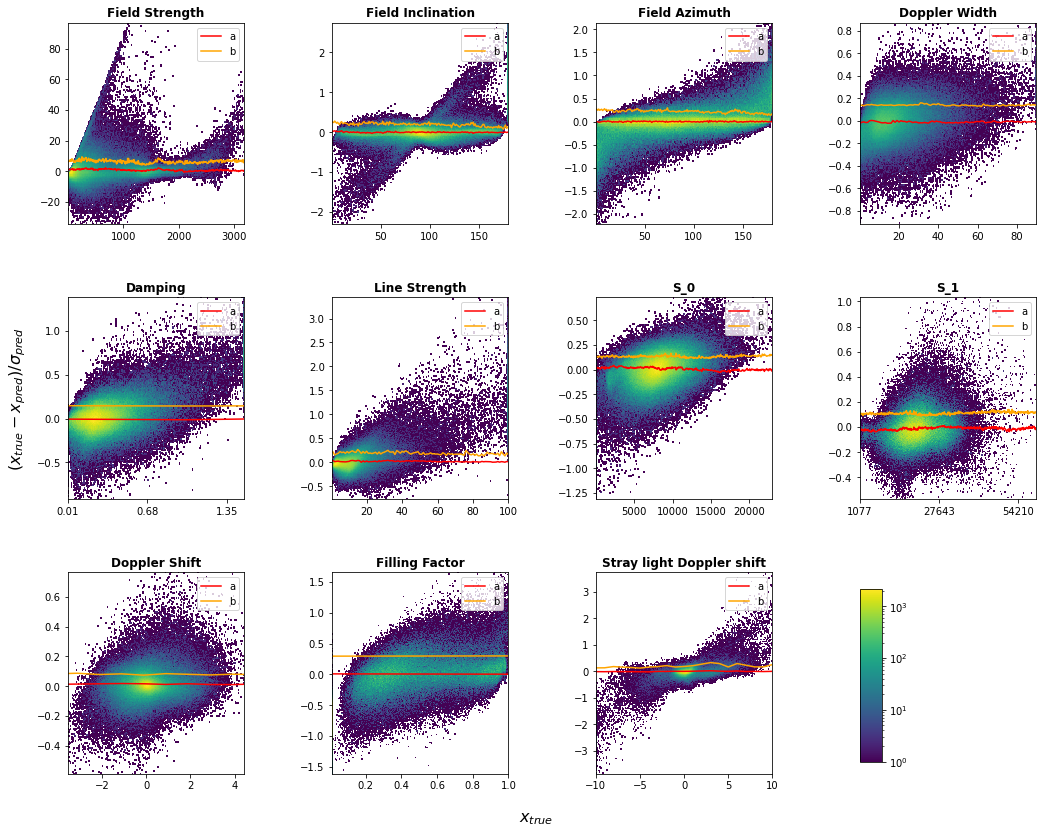

In [54]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
plot_analysis_hist2d_unc(true, pred, sigma, index=0, bins=300, save_path=save_path, title='refer_unnorm', plot_stats=True);

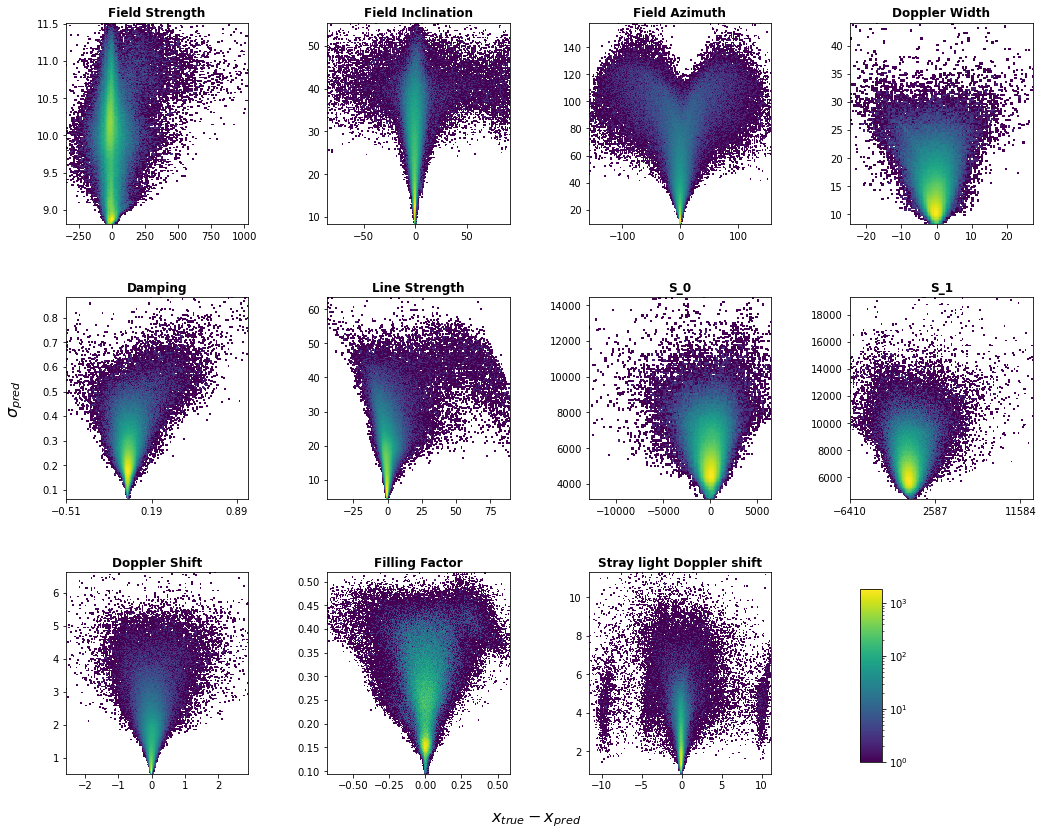

In [55]:
plot_analysis_hist2d_unc(true, pred, sigma, index=1, bins=300, save_path=save_path, title='refer_unnorm');

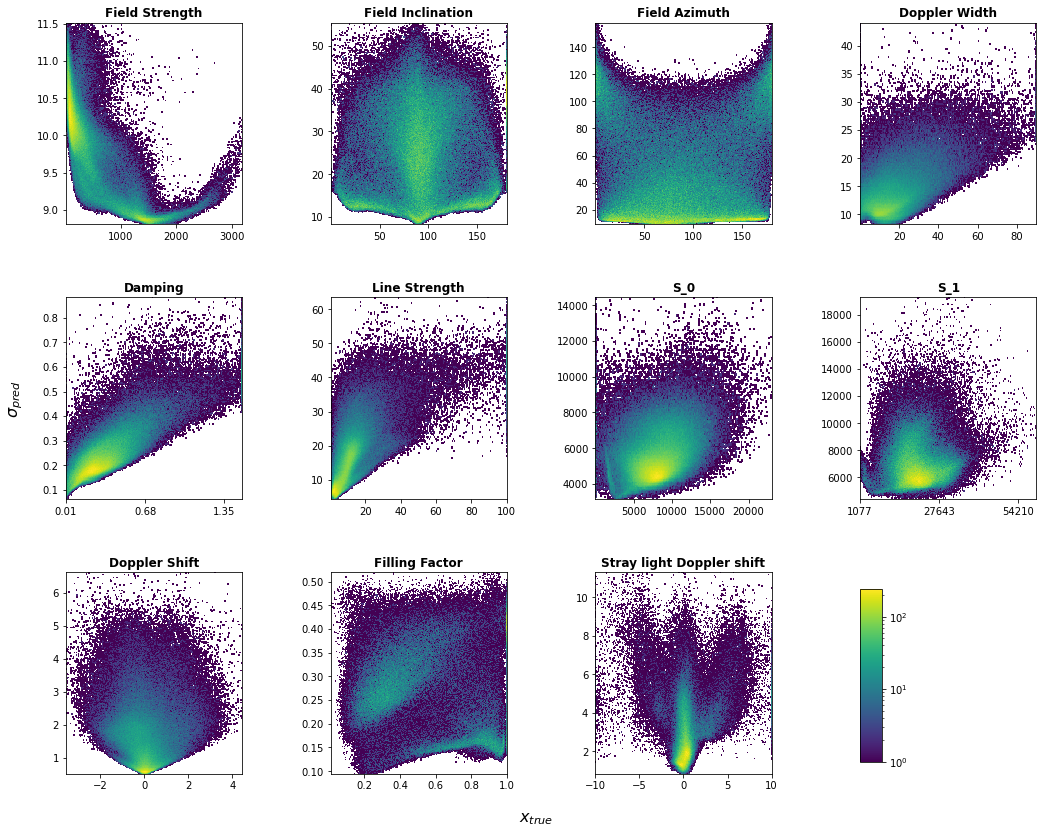

In [56]:
plot_analysis_hist2d_unc(true, pred, sigma, index=2, bins=300, save_path=save_path, title='refer_unnorm');